# training for xgboost models

In [2]:
import numpy as np
from sklearn import preprocessing
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
# load training data
Xtr_loadpath = 'Xtr.csv'
Xts_loadpath = 'Xts.csv'
ytr_loadpath = 'ytr.csv'

Xtr = np.loadtxt(Xtr_loadpath, delimiter=",")
Xts = np.loadtxt(Xts_loadpath, delimiter=",")
ytr = np.loadtxt(ytr_loadpath, delimiter=",")

In [4]:
# standardize the training data
scaler = StandardScaler()
Xtr_standardized = scaler.fit_transform(Xtr)
Xts_standardized = scaler.transform(Xts)

# save the standardized training data
Xtr_savepath = 'Xtr_standardized.csv'
Xts_savepath = 'Xts_standardized.csv'
ytr_savepath = 'ytr.csv'
yts_hat_savepath = 'yts_hat_xgboost.csv'

np.savetxt(Xtr_savepath, Xtr_standardized, delimiter=",")
np.savetxt(Xts_savepath, Xts_standardized, delimiter=",")
np.savetxt(ytr_savepath, ytr, delimiter=",")

### Step 1: Tune the learning rate and number of estimators

In [34]:
# give initial values to the parameters
xgbr = xgb.XGBRegressor(learning_rate =0.05, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=20)
param_test1 = {
 'learning_rate':[0.01,0.03,0.05,0.1,0.15],
 'n_estimators':[300,500,800,1000,1200]
}
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=param_test1,
                   scoring='r2', 
                   verbose=1)
clf.fit(X_train_standardized, y_train)
print("Best parameters:", clf.best_params_)
print("Highest R2: ", clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'learning_rate': 0.05, 'n_estimators': 1200}
Highest R2:  0.41613066219399253


In [46]:
pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["R2 score"])],axis=1)

,learning_rate,n_estimators,R2 score
0,0.01,300,0.277199
1,0.01,500,0.312149
2,0.01,800,0.341714
3,0.01,1000,0.355075
4,0.01,1200,0.365304
5,0.03,300,0.347837
6,0.03,500,0.374512
7,0.03,800,0.394125
8,0.03,1000,0.401452
9,0.03,1200,0.407045


In [47]:
xgbr.set_params(learning_rate=0.05,n_estimators=1200)
# Get training R2 and testing R2
# Fit the algorithm on the data
xgbr.fit(Xtr_standardized,ytr)
        
# Training set R2:
r2 = r2_score(ytr,xgbr.predict(Xtr_standardized))
print('training R2: ',r2)
# 5-fold cross validation R2 for these parameters
kf = KFold(n_splits=5,shuffle=True,random_state=0)
scores = cross_val_score(xgbr, Xtr_standardized, ytr, cv=kf, scoring='r2')
rsq_cv = np.mean(scores)
print("cross-validation R^2 = %f" % rsq_cv)

training R2:  0.99941784920738
cross-validation R^2 = 0.498806


### Step 2: Tune max_depth and min_child_weight.

In [48]:
param_test2 = {
 'max_depth':range(2,11,2),
 'min_child_weight':range(1,6,2)
}
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=param_test2,
                   scoring='r2', 
                   verbose=1)
clf.fit(X_train_standardized, y_train)
print("Best parameters:", clf.best_params_)
print("Highest R2: ", clf.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'max_depth': 10, 'min_child_weight': 1}
Highest R2:  0.4473296974131692


In [49]:
pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["R2 score"])],axis=1)

,max_depth,min_child_weight,R2 score
0,2,1,0.295349
1,2,3,0.296080
2,2,5,0.296524
3,4,1,0.383249
4,4,3,0.384782
5,4,5,0.384065
6,6,1,0.427618
7,6,3,0.426076
8,6,5,0.420600
9,8,1,0.443517


In [50]:
xgbr.set_params(max_depth=10, min_child_weight=1)
xgbr.fit(Xtr_standardized,ytr)
# Training set R2:
r2 = r2_score(ytr,xgbr.predict(Xtr_standardized))
print('training R2: ',r2)
# 5-fold cross validation R2 for these parameters
kf = KFold(n_splits=5,shuffle=True,random_state=0)
scores = cross_val_score(xgbr, Xtr_standardized, ytr, cv=kf, scoring='r2')
rsq_cv = np.mean(scores)
print("cross-validation R^2 = %f" % rsq_cv)

training R2:  0.99941784920738
cross-validation R^2 = 0.498806


### Step 3: Tune gamma.

In [51]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=param_test3,
                   scoring='r2', 
                   verbose=1)
clf.fit(X_train_standardized, y_train)
print("Best parameters:", clf.best_params_)
print("Highest R2: ", clf.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'gamma': 0.0}
Highest R2:  0.4477904347514047


In [52]:
pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["R2 score"])],axis=1)

,gamma,R2 score
0,0.0,0.447790
1,0.1,0.447330
2,0.2,0.446163
3,0.3,0.446425
4,0.4,0.444401


In [53]:
xgbr.set_params(gamma=0.1)
xgbr.fit(Xtr_standardized,ytr)
# Training set R2:
r2 = r2_score(ytr,xgbr.predict(Xtr_standardized))
print('training R2: ',r2)
# 5-fold cross validation R2 for these parameters
kf = KFold(n_splits=5,shuffle=True,random_state=0)
scores = cross_val_score(xgbr, Xtr_standardized, ytr, cv=kf, scoring='r2')
rsq_cv = np.mean(scores)
print("cross-validation R^2 = %f" % rsq_cv)

training R2:  0.99941784920738
cross-validation R^2 = 0.498806


### Step 4: Tune subsample and colsample_bytree

In [54]:
param_test4 = {
 'subsample':[i/10.0 for i in range(3,10)],
 'colsample_bytree':[i/10.0 for i in range(3,10)]
}

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=param_test4,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train_standardized, y_train)
print("Best parameters:", clf.best_params_)
print("Highest R2: ", clf.best_score_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Best parameters: {'colsample_bytree': 0.3, 'subsample': 0.6}
Highest R2:  -54.18163337737658


In [55]:
pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["R2 score"])],axis=1)

,colsample_bytree,subsample,R2 score
0,0.3,0.3,-57.205296
1,0.3,0.4,-55.294409
2,0.3,0.5,-55.000762
3,0.3,0.6,-54.181633
4,0.3,0.7,-54.834077
5,0.3,0.8,-54.268380
6,0.3,0.9,-54.621067
7,0.4,0.3,-56.643127
8,0.4,0.4,-55.308712
9,0.4,0.5,-55.791046


In [56]:
xgbr.set_params(subsample=0.9, colsample_bytree=0.3)
xgbr.fit(Xtr_standardized,ytr)
# Training set R2:
r2 = r2_score(ytr,xgbr.predict(Xtr_standardized))
print('training R2: ',r2)
# 5-fold cross validation R2 for these parameters
kf = KFold(n_splits=5,shuffle=True,random_state=0)
scores = cross_val_score(xgbr, Xtr_standardized, ytr, cv=kf, scoring='r2')
rsq_cv = np.mean(scores)
print("cross-validation R^2 = %f" % rsq_cv)

training R2:  0.99941784920738
cross-validation R^2 = 0.498806


### Step 5: Tuning L1 regularization parameters to do feature selection

In [57]:
param_test5 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05, 0.1]
}

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=param_test5,
                   scoring='r2', 
                   verbose=1)
clf.fit(X_train_standardized, y_train)
print("Best parameters:", clf.best_params_)
print("Highest R2: ", clf.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'reg_alpha': 0}
Highest R2:  0.4493476534300019


In [58]:
xgbr.set_params(reg_alpha=0.01)
xgbr.fit(Xtr_standardized,ytr)
# Training set R2:
r2 = r2_score(ytr,xgbr.predict(Xtr_standardized))
print('training R2: ',r2)
# 5-fold cross validation R2 for these parameters
kf = KFold(n_splits=5,shuffle=True,random_state=0)
scores = cross_val_score(xgbr, Xtr_standardized, ytr, cv=kf, scoring='r2')
rsq_cv = np.mean(scores)
print("cross-validation R^2 = %f" % rsq_cv)

training R2:  0.99941784920738
cross-validation R^2 = 0.498806


### Step 6: Tuning L2 regularization parameters to reduce overfitting

In [59]:
param_test6 = {
 'reg_lambda':[0, 0.001, 0.005, 0.01, 0.05, 0.1]
}

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=param_test6,
                   scoring='r2', 
                   verbose=1)
clf.fit(X_train_standardized, y_train)
print("Best parameters:", clf.best_params_)
print("Highest R2: ", clf.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'reg_lambda': 0}
Highest R2:  0.4434791576636215


In [60]:
pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["R2 score"])],axis=1)

,reg_lambda,R2 score
0,0.000,0.443479
1,0.001,0.438009
2,0.005,0.439788
3,0.010,0.441402
4,0.050,0.442469
5,0.100,0.443078


In [61]:
xgbr.set_params(reg_lambda=0.01)
xgbr.fit(Xtr_standardized,ytr)
# Training set R2:
r2 = r2_score(ytr,xgbr.predict(Xtr_standardized))
print('training R2: ',r2)
# 5-fold cross validation R2 for these parameters
kf = KFold(n_splits=5,shuffle=True,random_state=0)
scores = cross_val_score(xgbr, Xtr_standardized, ytr, cv=kf, scoring='r2')
rsq_cv = np.mean(scores)
print("cross-validation R^2 = %f" % rsq_cv)

training R2:  0.9996549235422361
cross-validation R^2 = 0.486245


### So the final tuned model parameters are as follows:

In [62]:
xgbr = xgb.XGBRegressor(learning_rate =0.05, n_estimators=1200, max_depth=10, colsample_bytree=0.3, gamma=0.1, reg_alpha=0.01,
 objective= 'reg:squarederror', nthread=4, subsample= 0.9,seed=20)
xgbr.fit(Xtr_standardized,ytr)
# Training set R2:
r2 = r2_score(ytr,xgbr.predict(Xtr_standardized))
print('training R2: ',r2)
# 5-fold cross validation R2 for these parameters
kf = KFold(n_splits=5,shuffle=True,random_state=0)
scores = cross_val_score(xgbr, Xtr_standardized, ytr, cv=kf, scoring='r2')
rsq_cv = np.mean(scores)
print("cross-validation R^2 = %f" % rsq_cv)

training R2:  0.99941784920738
cross-validation R^2 = 0.498806


### output the feature importance

<AxesSubplot:>

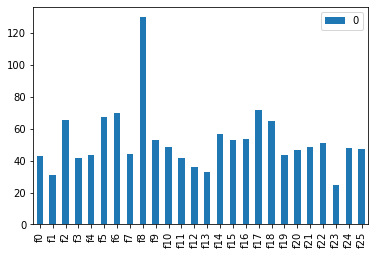

In [63]:
xgbr.fit(Xtr_standardized,ytr)
f_importance = xgbr.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame.from_dict(data=f_importance, 
                                       orient='index')
importance_df.plot.bar()

In [64]:
# save the model: you must use the .json format for xgboost models!
model_savepath = 'model.json'
xgbr.save_model(model_savepath)

In [65]:
# generate kaggle submission file using the validation script
!python {"validation.py " + model_savepath + " --Xts_path " + Xts_savepath + " --Xtr_path " + Xtr_savepath + " --yts_hat_path " + yts_hat_savepath }

training R2 =  0.99941784920738
test target predictions saved in yts_hat_xgboost.csv
